# Project Description
In this project I am going to see if I can visualize graphically the difference between two different types of book genres. The two book genres I am choosing to compare are cook books and gothic/horror. Before I do that tho I will start with a smaller example. First I will try to visualize positive and negative words. The way in which I will do this is by embedding some word data. This means I will turn some word `positive_word` into a vector (`[34 , 423, 5, ....  6456 , 343]`). I will get the word embeddings by using the BERT model. Once I have the embeddings I will use dimensionality reduction algorithms (PCA, TSNE) to get them down to a vector of two components. Lastly once I have done this I will then use the book data to do the same. This notebook will not go too much into the techincal aspects of BERT, PCA, TSNE. I am simply using tools to visualize text data.

# The Data
First lets take a look at our data. As I mentioned first I will be using a small dataset that I created. The data can be found in the folder `./data/csv/words.csv`. It consists of two columns (word, label). Here are two examples `word=love,label=positive, word=hate,label=negative`. I will put each word through the bert model to get some embeddings. Then I will use a dimensionalty reduction algorithm to plot each word. 
Later on I will be using book data. This data has two columns. I got this data from [here](https://www.gutenberg.org/). First we will import some useful tools that will help us.

In [1]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizer, BertModel

# First Example

In [2]:
data = pd.read_csv('./data/csv/words.csv')

Here is our data. As we can see it is really simple. We have a word and its label.

In [3]:
data.head()

,word,label
0,love,positive
1,terrific,positive
2,admired,positive
3,jolly,positive
4,brave,positive


In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
# tokenize every word in the dataframe
encoded_data = [tokenizer(i, return_tensors='pt') for i in data.word]

In [6]:
# Our words have been encoded into a list of ids that look like this: tensor([[ 101, 3866,  102]]). 
# 101 and 102 are for start and stop. 3866 is the id of our actual word embedding and its what we actually
# need. We will extract this later.
encoded_data[0]

{'input_ids': tensor([[ 101, 2293,  102]]), 'token_type_ids': tensor([[0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1]])}

In [7]:
# Get the embeddings from our encoded data
word_embeddings = [model(**i) for i in encoded_data]

In [8]:
word_embeddings[0].last_hidden_state.shape

torch.Size([1, 3, 768])

In [9]:
# Get the last hidden state for each of the embeddings
embeddings = [i.last_hidden_state for i in word_embeddings]

In [10]:
# Get the actual word embeddings. 
embeddings = [i[0][1] for i in embeddings]

In [11]:
# Turn tensor to numpy array
embeddings = [i.detach().numpy() for i in embeddings]

In [12]:
# Add the embeddings to our dataframe
data['word_embeddings'] = embeddings

We now have all the embeddings for our words. We can see this in the dataframe below in the column `word_embeddings`. Now that we have our embeddings we will reduce the vectors.

In [13]:
data.head()

,word,label,word_embeddings
0,love,positive,"[0.3864911, 0.36188018, 0.23423323, -0.3957976..."
1,terrific,positive,"[0.33330113, -0.20869666, -0.16522153, -0.0631..."
2,admired,positive,"[-0.25650173, 0.022439439, 0.25480777, -0.0880..."
3,jolly,positive,"[-0.22022377, -0.20243204, 0.10135944, -0.3264..."
4,brave,positive,"[-0.08306653, -0.118995346, -0.46022722, -0.43..."


# Visualizing
A issue with our data is that it is very high dimensional. As we can see below the shape for one example is very big. We can't just graph this so we are going to be using a some dimensionality reduction algorithms. First we are going to use PCA (prinicpal component analysis) and TSNE (T-distributed Stochastic Neighbourhood Embedding). I will not go into how these algorthims work here but you can read about them here [TSNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis#:~:text=Principal%20component%20analysis%20(PCA)%20is,components%20and%20ignoring%20the%20rest.)

In [14]:
data.word_embeddings[0].shape

(768,)

In [15]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(list(data.word_embeddings))
principal_df = pd.DataFrame(data = principal_components, columns=['pc_one', 'pc_two'])

In [16]:
# Our data reduced to two components by pca
principal_df.head()

,pc_one,pc_two
0,1.714281,0.511747
1,-0.681739,-3.310147
2,-1.780258,0.753338
3,-3.881720,-0.769071
4,-2.737801,0.931425


In [17]:
# Add our reduced data to our main dataframe
data = pd.concat([data, principal_df], axis=1)

In [18]:
data.head()

,word,label,word_embeddings,pc_one,pc_two
0,love,positive,"[0.3864911, 0.36188018, 0.23423323, -0.3957976...",1.714281,0.511747
1,terrific,positive,"[0.33330113, -0.20869666, -0.16522153, -0.0631...",-0.681739,-3.310147
2,admired,positive,"[-0.25650173, 0.022439439, 0.25480777, -0.0880...",-1.780258,0.753338
3,jolly,positive,"[-0.22022377, -0.20243204, 0.10135944, -0.3264...",-3.881720,-0.769071
4,brave,positive,"[-0.08306653, -0.118995346, -0.46022722, -0.43...",-2.737801,0.931425


In [19]:
# split the word embeddings by label (positive/negative)
positive = data.query('label.str.contains("positive")', engine='python')
negative = data.query('label.str.contains("negative")', engine='python')

<!-- Below we is a graph of our words graphed. We can see that the positive words are on the upper left of the chart and the negative words are in the middle to the right of the positive words. We can also see that they slightly overlap in the middle. We can also see that there are words that -->

Below I have graphed our data in its reduced form by pca. As we can see there is some noticeable difference but not much. We can see that there are more negative words in the upper right of the graph. And generally most positive words are in the bottom left. One of the reasons why this did not work as we expected is because pca is meant for linear data which our data is not. Now we are going to use TSNE to see if we can get a better result.

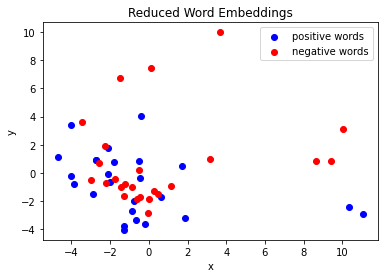

In [20]:
plt.scatter(positive.pc_one, positive.pc_two, color='b')
plt.scatter(negative.pc_one, negative.pc_two, color='r')
plt.legend(['positive words', 'negative words'], loc ='upper right')
plt.title('Reduced Word Embeddings')
plt.xlabel('x')
plt.ylabel('y')
plt.show();

In [21]:
def compare_words(data):
    """
    Function to compare a word to other words in a pandas dataframe.
    """
    similarities = {}
    for i in range(len(data)):
        current_embedding = data.loc[i].word_embeddings.reshape(1, -1)
        current_word = data.loc[i].word
        most_similar = 0
        for j in range(len(data)):
            other_embedding = data.loc[j].word_embeddings.reshape(1, -1)
            other_word = data.loc[j].word
            similarity = cosine_similarity(current_embedding, other_embedding)
            if similarity >= most_similar and current_word != other_word:
                similarities[current_word] = other_word
                most_similar = similarity
    return similarities

# TODO: Explain the similarities below

In [22]:
similarities = compare_words(data)
similarities

{'love': 'hate',
 'terrific': 'wonderful',
 'admired': 'courageous',
 'jolly': 'lively',
 'brave': 'courageous',
 'fun': 'nice',
 'engaged': 'courageous',
 'happy': 'sad',
 'wonderful': 'amazing',
 'hopeful': 'frustrated',
 'free': 'frustrated',
 'confident': 'frustrated',
 'secure': 'confident',
 'lively': 'jolly',
 'amazing': 'awesome',
 'friendly': 'failure',
 'awesome': 'amazing',
 'beautiful': 'amazing',
 'kind': 'frustrated',
 'strong': 'helpless',
 'joyful': 'happy',
 'courageous': 'brave',
 'carefree': 'joyful',
 'nice': 'strong',
 'rejected': 'admired',
 'afraid': 'scared',
 'regretful': 'displeased',
 'coward': 'helpless',
 'embarrassed': 'disgusted',
 'sad': 'lonely',
 'lonely': 'frustrated',
 'alone': 'lonely',
 'displeased': 'disgusted',
 'panic': 'terrified',
 'terrified': 'scared',
 'loser': 'failure',
 'frustrated': 'scared',
 'lost': 'loser',
 'feeble': 'displeased',
 'failure': 'rejected',
 'helpless': 'terrified',
 'disgusted': 'embarrassed',
 'ugly': 'disgusting',
 

In [23]:
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(list(data.word_embeddings))

[t-SNE] Computing 49 nearest neighbors...
[t-SNE] Indexed 50 samples in 0.001s...
[t-SNE] Computed neighbors for 50 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 50 / 50
[t-SNE] Mean sigma: 5.554680
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.597054
[t-SNE] KL divergence after 1000 iterations: 0.430304


C:\Users\Gael Gil\Desktop\git-repos\notebooks\book_genre_comparison\env\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Gael Gil\Desktop\git-repos\notebooks\book_genre_comparison\env\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [24]:
df = pd.DataFrame()
# get our first component
df["comp_one"] = z[:,0]
# get our second component
df["comp_two"] = z[:,1]
# add our reduced data into our dataframe
data = pd.concat([data, df], axis=1)

In [25]:
positive = data.query('label.str.contains("positive")', engine='python')
negative = data.query('label.str.contains("negative")', engine='python')

Below I have graphed our data in its reduced form by tsne. # TODO: Finish explaning the graph below

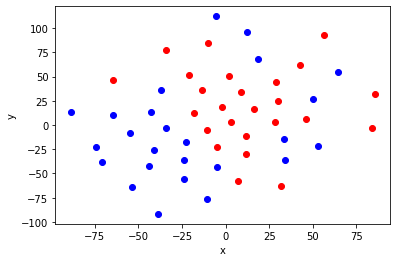

In [26]:
plt.scatter(positive.comp_one, positive.comp_two, color='b')
plt.scatter(negative.comp_one, negative.comp_two, color='r')
plt.xlabel('x')
plt.ylabel('y')
plt.show();

# Using the Book Dataset
Now we are going to attempt to see if we can try and do the same for a whole book.

In [27]:
books = pd.read_csv('./data/csv/data.csv')

In [28]:
books

,book,words
0,./data/cook_book_one.txt,project gutenberg's the whitehouse cookbook by...
1,./data/cook_book_three.txt,the project gutenberg ebook of new royal cook ...
2,./data/gothic_novel_four.txt,the project gutenberg ebook of the works of ed...
3,./data/gothic_novel_six.txt,the project gutenberg ebook of northanger abbe...
4,./data/gothic_novel_two.txt,project gutenberg’s the complete works of will...
5,./data/gothic_novel_three.txt,the project gutenberg ebook of dracula by bram...
6,./data/cook_book_four.txt,the project gutenberg ebook of the italian coo...
7,./data/gothic_novel_ten.txt,the project gutenberg ebook of the castle of o...
8,./data/gothic_novel_eight.txt,the project gutenberg ebook of the vampyre a t...
9,./data/gothic_novel_nine.txt,the project gutenberg ebook of the masque of t...
